# Joern-ey into Progol

We have [generated](./generate_minimal_ilp_dataset.ipynb) a subset of the Juliet dataset consisting of small buffer overflow examples, and have [transformed](./Joern-ey%20into%20ILP.ipynb) each piece of source code into a a set of Prolog facts. In this notebook we generate Progol scripts from this dataset, and try to get it to learn rules to determine when a buffer overflow occurs.

## Generating Progol
In this section we load in the ILP dataset and its Progol representations, manually find the "error" node in each example, then define the `make_progol_script` function which will generate a script from the given testcase id's.

In [1]:
import pandas as pd

In [2]:
import tempfile
import subprocess
import graph_visualisation

In [3]:
ilp_data = pd.read_csv("../data/ilp_dataset.csv.gz")
ilp_data = ilp_data.drop("Unnamed: 0", axis=1)
ilp_data

,testcase_ID,filename,code,flaw,flaw_loc,bug,code_length
0,62804,000/062/804/CWE121_Stack_Based_Buffer_Overflow...,/* TEMPLATE GENERATED TESTCASE FILE\nFilename:...,CWE-121,33,False,1722
1,62852,000/062/852/CWE121_Stack_Based_Buffer_Overflow...,/* TEMPLATE GENERATED TESTCASE FILE\nFilename:...,CWE-121,30,False,1674
2,62853,000/062/853/CWE121_Stack_Based_Buffer_Overflow...,/* TEMPLATE GENERATED TESTCASE FILE\nFilename:...,CWE-121,33,False,2396
3,62854,000/062/854/CWE121_Stack_Based_Buffer_Overflow...,/* TEMPLATE GENERATED TESTCASE FILE\nFilename:...,CWE-121,33,False,2414
4,62869,000/062/869/CWE121_Stack_Based_Buffer_Overflow...,/* TEMPLATE GENERATED TESTCASE FILE\nFilename:...,CWE-121,32,False,1760
5,62900,000/062/900/CWE121_Stack_Based_Buffer_Overflow...,/* TEMPLATE GENERATED TESTCASE FILE\nFilename:...,CWE-121,30,False,1680
6,62901,000/062/901/CWE121_Stack_Based_Buffer_Overflow...,/* TEMPLATE GENERATED TESTCASE FILE\nFilename:...,CWE-121,33,False,2403
7,62917,000/062/917/CWE121_Stack_Based_Buffer_Overflow...,/* TEMPLATE GENERATED TESTCASE FILE\nFilename:...,CWE-121,32,False,1766
8,232012,000/232/012/CWE122_Heap_Based_Buffer_Overflow_...,/* TEMPLATE GENERATED TESTCASE FILE\nFilename:...,CWE-122,31,False,1723
9,232086,000/232/086/CWE122_Heap_Based_Buffer_Overflow_...,/* TEMPLATE GENERATED TESTCASE FILE\nFilename:...,CWE-122,31,False,1729


In [4]:
prolog = pd.read_csv("../data/ilp_prolog_data.csv.gz")
prolog = prolog.drop("Unnamed: 0", axis=1)
prolog

,testcase_ID,flaw,bug,code_length,tree,source_map
0,-232086,CWE-122,True,1625,% START: Generated Prolog\n% NODE PROPERTIES \...,"% CODE\nsource_code(bad_232086_id_1_f_l_c_, ""p..."
1,-232012,CWE-122,True,1619,% START: Generated Prolog\n% NODE PROPERTIES \...,% CODE\nsource_code(bad_232012_id_1_f_l_48_c_1...
2,-62917,CWE-121,True,1622,% START: Generated Prolog\n% NODE PROPERTIES \...,"% CODE\nsource_code(bad_62917_id_0_f_l_c_, ""p1..."
3,-62901,CWE-121,True,1627,% START: Generated Prolog\n% NODE PROPERTIES \...,"% CODE\nsource_code(bad_62901_id_0_f_l_c_, ""p1..."
4,-62900,CWE-121,True,1576,% START: Generated Prolog\n% NODE PROPERTIES \...,"% CODE\nsource_code(bad_62900_id_0_f_l_c_, ""p2..."
5,-62869,CWE-121,True,1616,% START: Generated Prolog\n% NODE PROPERTIES \...,"% CODE\nsource_code(bad_62869_id_0_f_l_c_, ""p1..."
6,-62854,CWE-121,True,1630,% START: Generated Prolog\n% NODE PROPERTIES \...,"% CODE\nsource_code(bad_62854_id_0_f_l_c_, ""p1..."
7,-62853,CWE-121,True,1621,% START: Generated Prolog\n% NODE PROPERTIES \...,"% CODE\nsource_code(bad_62853_id_0_f_l_c_, ""p1..."
8,-62852,CWE-121,True,1570,% START: Generated Prolog\n% NODE PROPERTIES \...,"% CODE\nsource_code(bad_62852_id_0_f_l_c_, ""p3..."
9,-62804,CWE-121,True,1618,% START: Generated Prolog\n% NODE PROPERTIES \...,"% CODE\nsource_code(bad_62804_id_0_f_l_c_, ""p1..."


In [5]:
good_examples = prolog[prolog['bug'] == False]
bad_examples = prolog[prolog['bug'] == True]

In [6]:
def extract_node_ids(tree):
    nodes = set()
    
    in_ast_section = False
    
    for line in tree.split('\n'):
        line = line.strip()
        
        if line == '% AST':
            in_ast_section = True
        
        if line == '% CFG':
            in_ast_section = False
            
        if line == '% REF':
            in_ast_section = False
        
        if in_ast_section and not line.startswith("%"):
            parent, child = line[4:-2].split(", ")
            nodes.add(parent)
            nodes.add(child)
            
    return nodes

In [7]:
# good nodes_g
nodes_g = set()

for i in range(len(good_examples)):
    good_nodes = extract_node_ids(good_examples.iloc[i].tree)
    nodes_g = set.union(nodes_g,good_nodes)

    
# bad nodes_b
nodes_b = set()

for i in range(len(bad_examples)):
    bad_nodes = extract_node_ids(bad_examples.iloc[i].tree)
    nodes_b = set.union(nodes_b,bad_nodes)

nodes = set.union(nodes_g,nodes_b)


Manually find the "error" node for each testcase, and tag those as the positive or  negative examples.

In [8]:
print(good_examples.source_map.iloc[9])

% CODE
source_code(good_232086_id_1_f_l_c_, "p1").
source_code(good_232086_id_2_f_l_c_, "p1").
source_code(good_232086_id_3_f_l_54_c_9_, "int argc").
source_code(good_232086_id_4_f_l_c_, "p1").
source_code(good_232086_id_5_f_l_c_, "p1").
source_code(good_232086_id_6_f_l_c_, "p3").
source_code(good_232086_id_7_f_l_c_, "p1").
source_code(good_232086_id_8_f_l_c_, "p2").
source_code(good_232086_id_9_f_l_c_, "p1").
source_code(good_232086_id_10_f_l_c_, "p1").
source_code(good_232086_id_11_f_l_c_, "p2").
source_code(good_232086_id_12_f_l_c_, "p2").
source_code(good_232086_id_13_f_l_c_, "p2").
source_code(good_232086_id_14_f_l_c_, "p1").
source_code(good_232086_id_15_f_l_c_, "p2").
source_code(good_232086_id_16_f_l_54_c_19_, "char * argv[]").
source_code(good_232086_id_17_f_l_c_, "p1").
source_code(good_232086_id_18_f_l_c_, "p2").
source_code(good_232086_id_19_f_l_c_, "p1").
source_code(good_232086_id_20_f_l_c_, "p1").
source_code(good_232086_id_21_f_l_c_, "p1").
source_code(good_232086_id_22

In [9]:
types = [
    'node('+node_id+').' for node_id in nodes
]

positive_examples = [
    """
    bug(bad_232086_id_146_f_memmove_01_c_l_30_c_8_).
    bug(bad_232012_id_145_f_memcpy_01_c_l_30_c_8_).
    bug(bad_62917_id_121_f_memmove_18_c_l_31_c_8_).
    bug(bad_62901_id_120_f_memmove_02_c_l_32_c_8_).
    bug(bad_62900_id_120_f_memmove_01_c_l_29_c_8_).
    bug(bad_62869_id_120_f_memcpy_18_c_l_31_c_8_).
    bug(bad_62854_id_128_f_memcpy_03_c_l_32_c_8_).
    bug(bad_62853_id_121_f_memcpy_02_c_l_32_c_8_).
    bug(bad_62852_id_120_f_memcpy_01_c_l_29_c_8_).
    bug(bad_62804_id_110_f_loop_01_c_l_32_c_12_).
    """,
]

negative_examples = [
    """
:- bug(good_62804_id_129_f_loop_01_c_l_34_c_12_).
:- bug(good_62852_id_126_f_memcpy_01_c_l_31_c_8_).
:- bug(good_62853_id_118_f_memcpy_02_c_l_57_c_8_).
:- bug(good_62854_id_130_f_memcpy_03_c_l_57_c_8_).
:- bug(good_62869_id_126_f_memcpy_18_c_l_33_c_8_).
:- bug(good_62900_id_125_f_memmove_01_c_l_31_c_8_).
:- bug(good_62901_id_118_f_memmove_02_c_l_57_c_8_).
:- bug(good_62917_id_125_f_memmove_18_c_l_33_c_8_).
:- bug(good_232012_id_150_f_memcpy_01_c_l_32_c_8_).
:- bug(good_232086_id_150_f_memmove_01_c_l_32_c_8_).
    """,
]


In [10]:
def make_progol_script(header, testcases):
    script_template = """
{header}

%% Types
{types}

%% background knowledge
{bg_knowledge}

%% learning task
%% positive examples
{positive_examples}

%% negative examples
{negative_examples}

    """

    script = script_template.format(
        header = header,
        types = '\n'.join(types),
        bg_knowledge = '\n'.join(prolog['tree']),
        positive_examples='\n'.join(positive_examples),
        negative_examples='\n'.join(negative_examples),
    )
    
    # remove all lines not related to this testcase
    script = '\n'.join([
        line for line in script.split("\n")  if any(
            str(testcase) in line for testcase in testcases
        ) or not ("good_" in line or "bad_" in line)
    ])
    
    return script

## Experimentation
In this section we try different subsets of the dataset with different Progol settings. 

We try by setting the following header:

In [11]:
header = """
% Settings
:- set(c,30)?
:- set(i,30)?
:- set(h,500)?
:- set(cover)?
:- set(inflate,500)?

% Mode declarations
:- modeh(*, bug(+node))?

:- modeb(*, ast(+node,-node))?

:- modeb(*, ref(+node,-node))?
:- modeb(*, ref(-node,+node))?

:- modeb(*, assignment(+node))?
:- modeb(*, compMemberAccess(+node))?
:- modeb(*, sizeOf(+node))?
:- modeb(*, malloc(+node))?
:- modeb(*, alloc(+node))?
:- modeb(*, writeToPointer(+node))?
"""

script = make_progol_script(header, {62804, 62852, 62869, 232012, 62900})

with open("/tmp/progol_input.pl", "w") as f:
    f.write(script)

!/progol/source/progol /tmp/progol_input.pl

CProgol Version 5.0

[:- set(c,30)? - Time taken 0.00s]
[:- set(i,30)? - Time taken 0.00s]
[:- set(h,500)? - Time taken 0.00s]
[The cover flag has been turned ON]
[:- set(cover)? - Time taken 0.00s]
[:- set(inflate,500)? - Time taken 0.00s]
[:- modeh(100,bug(+node))? - Time taken 0.00s]
[:- modeb(100,ast(+node,-node))? - Time taken 0.00s]
[:- modeb(100,ref(+node,-node))? - Time taken 0.00s]
[:- modeb(100,ref(-node,+node))? - Time taken 0.00s]
[:- modeb(100,assignment(+node))? - Time taken 0.00s]
[:- modeb(100,compMemberAccess(+node))? - Time taken 0.00s]
[:- modeb(100,sizeOf(+node))? - Time taken 0.00s]
[:- modeb(100,malloc(+node))? - Time taken 0.00s]
[:- modeb(100,alloc(+node))? - Time taken 0.00s]
[:- modeb(100,writeToPointer(+node))? - Time taken 0.00s]
[Testing for contradictions]
[No contradictions found]
[Generalising bug/1]
[Generalising bug(bad_232012_id_145_f_memcpy_01_c_l_30_c_8_).]
[Generalising <bug(bad_232012_id_145_f_memcpy_01_c_l_30_c_8_).>]
bug(A) :- ast(A,B), ast(A,C)

This creates one rule per example, but is unable to create a general one. These rules succinctly describe the situation, and three of the examples have the same rule!

```
bug(A) :- ast(A,B), ast(A,C), ast(B,D), ref(C,E), ast(D,F), sizeOf(D).
bug(A) :- ast(A,B), ast(A,C), writeToPointer(A), ast(B,D), ref(C, E), ast(D,F), sizeOf(D).
bug(A) :- ast(A,B), ast(A,C), ast(B,D), ref(C,E), ast(D,F), sizeOf(D).
bug(A) :- ast(A,B), ast(A,C), ast(B,D), ref(C,E), ast(D,F), sizeOf(D).
bug(A) :- ast(A,B), assignment(A), ast(B,C), compMemberAccess(B), ref(C,D).
```

We try the same setup, but only for those buffer overflows which happen due to a `memcpy`:

In [12]:
script = make_progol_script(header, {
    62852,
    62853,
    62854,
    62869,
    232012,
})

with open("/tmp/progol_input.pl", "w") as f:
    f.write(script)

!/progol/source/progol /tmp/progol_input.pl

CProgol Version 5.0

[:- set(c,30)? - Time taken 0.00s]
[:- set(i,30)? - Time taken 0.00s]
[:- set(h,500)? - Time taken 0.00s]
[The cover flag has been turned ON]
[:- set(cover)? - Time taken 0.00s]
[:- set(inflate,500)? - Time taken 0.00s]
[:- modeh(100,bug(+node))? - Time taken 0.00s]
[:- modeb(100,ast(+node,-node))? - Time taken 0.00s]
[:- modeb(100,ref(+node,-node))? - Time taken 0.00s]
[:- modeb(100,ref(-node,+node))? - Time taken 0.00s]
[:- modeb(100,assignment(+node))? - Time taken 0.00s]
[:- modeb(100,compMemberAccess(+node))? - Time taken 0.00s]
[:- modeb(100,sizeOf(+node))? - Time taken 0.00s]
[:- modeb(100,malloc(+node))? - Time taken 0.00s]
[:- modeb(100,alloc(+node))? - Time taken 0.00s]
[:- modeb(100,writeToPointer(+node))? - Time taken 0.00s]
[Testing for contradictions]
[No contradictions found]
[Generalising bug/1]
[Generalising bug(bad_232012_id_145_f_memcpy_01_c_l_30_c_8_).]
[Generalising <bug(bad_232012_id_145_f_memcpy_01_c_l_30_c_8_).>]
bug(A) :- ast(A,B), ast(A,C)

It produces 5 of the exact same "most specific clauses", but is still unable to give a final output?
```
bug(A) :- ast(A,B), ast(A,C), ast(B,D), ref(C,E), ast(D,F), sizeOf(D).
bug(A) :- ast(A,B), ast(A,C), ast(B,D), ref(C,E), ast(D,F), sizeOf(D).
bug(A) :- ast(A,B), ast(A,C), ast(B,D), ref(C,E), ast(D,F), sizeOf(D).
bug(A) :- ast(A,B), ast(A,C), ast(B,D), ref(C,E), ast(D,F), sizeOf(D).
bug(A) :- ast(A,B), ast(A,C), ast(B,D), ref(C,E), ast(D,F), sizeOf(D).
```

**Question:** Why is it unable to combine them?

Finally, try for all the examples:

In [13]:
script = make_progol_script(header, {
    62804,
    62852,
    62853,
    62854,
    62869,
    62900,
    62901,
    62917,
    232012,
    232086,
})

with open("/tmp/progol_input.pl", "w") as f:
    f.write(script)

!/progol/source/progol /tmp/progol_input.pl

CProgol Version 5.0

[:- set(c,30)? - Time taken 0.00s]
[:- set(i,30)? - Time taken 0.00s]
[:- set(h,500)? - Time taken 0.00s]
[The cover flag has been turned ON]
[:- set(cover)? - Time taken 0.00s]
[:- set(inflate,500)? - Time taken 0.00s]
[:- modeh(100,bug(+node))? - Time taken 0.00s]
[:- modeb(100,ast(+node,-node))? - Time taken 0.00s]
[:- modeb(100,ref(+node,-node))? - Time taken 0.00s]
[:- modeb(100,ref(-node,+node))? - Time taken 0.00s]
[:- modeb(100,assignment(+node))? - Time taken 0.00s]
[:- modeb(100,compMemberAccess(+node))? - Time taken 0.00s]
[:- modeb(100,sizeOf(+node))? - Time taken 0.00s]
[:- modeb(100,malloc(+node))? - Time taken 0.00s]
[:- modeb(100,alloc(+node))? - Time taken 0.00s]
[:- modeb(100,writeToPointer(+node))? - Time taken 0.00s]
[Testing for contradictions]
[No contradictions found]
[Generalising bug/1]
[Generalising bug(bad_232086_id_146_f_memmove_01_c_l_30_c_8_).]
[Generalising <bug(bad_232086_id_146_f_memmove_01_c_l_30_c_8_).>]
bug(A) :- ast(A,B), ast(A,

It produces two different rules (grouped below by rule not output or testcase):

```
bug(A) :- ast(A,B), ast(A,C), writeToPointer(A), ast(B,D), ref(C, E), ast(D,F), sizeOf(D).
bug(A) :- ast(A,B), ast(A,C), writeToPointer(A), ast(B,D), ref(C, E), ast(D,F), sizeOf(D).
bug(A) :- ast(A,B), ast(A,C), writeToPointer(A), ast(B,D), ref(C, E), ast(D,F), sizeOf(D).
bug(A) :- ast(A,B), ast(A,C), writeToPointer(A), ast(B,D), ref(C, E), ast(D,F), sizeOf(D).
bug(A) :- ast(A,B), ast(A,C), writeToPointer(A), ast(B,D), ref(C, E), ast(D,F), sizeOf(D).
bug(A) :- ast(A,B), ast(A,C), writeToPointer(A), ast(B,D), ref(C, E), ast(D,F), sizeOf(D).
bug(A) :- ast(A,B), ast(A,C), writeToPointer(A), ast(B,D), ref(C, E), ast(D,F), sizeOf(D).
bug(A) :- ast(A,B), ast(A,C), writeToPointer(A), ast(B,D), ref(C, E), ast(D,F), sizeOf(D).
bug(A) :- ast(A,B), ast(A,C), writeToPointer(A), ast(B,D), ref(C, E), ast(D,F), sizeOf(D).
bug(A) :- ast(A,B), assignment(A), ast(B,C), compMemberAccess(B), ref(C,D).
```

The first rule is generated for all buffer overflows which make use of a bulk memory operation (e.g. `memcpy` and `memmove`) whilst the second rule is for the examples where an array is copied item by item. 

What do these rules mean? Let's visualise them to find out:

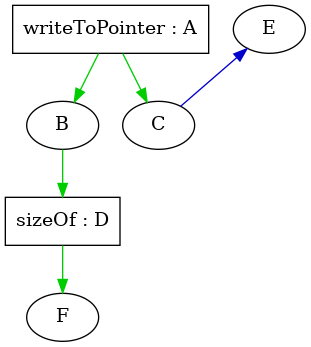

In [15]:
graph_visualisation.jupyter_display_graph(graph_visualisation.prolog_rule_to_dot(
        "bug(A) :- ast(A,B), ast(A,C), writeToPointer(A), ast(B,D), ref(C,E), ast(D,F), sizeOf(D)."
))

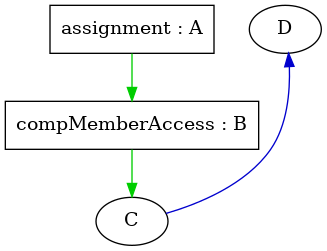

In [16]:
graph_visualisation.jupyter_display_graph(graph_visualisation.prolog_rule_to_dot(
        "bug(A) :- ast(A,B), assignment(A), ast(B,C), compMemberAccess(B), ref(C,D)."
))

**Question:** Can ILP learn logical or's? And so could these three rules be considered in composite?

**Question:** Can we create probabilistic model from these rules?

In [18]:
script = make_progol_script("""
% Settings
:- set(c,40)?
:- set(i,40)?
:- set(h,500)?
:- set(cover)?
:- set(inflate,200)?
:- set(noise,0.2)?

% Mode declarations
:- modeh(*, bug(+node))?

:- modeb(*, ast(+node,-node))?

:- modeb(*, cfg(+node,-node))?
:- modeb(*, cfg(-node,+node))?

:- modeb(*, ref(+node,-node))?
:- modeb(*, ref(-node,+node))?

:- modeb(*, assignment(+node))?
:- modeb(*, compMemberAccess(+node))?
:- modeb(*, sizeOf(+node))?
:- modeb(*, malloc(+node))?
:- modeb(*, alloc(+node))?
:- modeb(*, writeToPointer(+node))? """, {
    62804,
    62852,
    62853,
    62854,
    62869,
    62900,
    62901,
    62917,
    232012,
    232086,
})

with open("/tmp/progol_input.pl", "w") as f:
    f.write(script)

!/progol/source/progol /tmp/progol_input.pl

CProgol Version 5.0

[:- set(c,40)? - Time taken 0.00s]
[:- set(i,40)? - Time taken 0.00s]
[:- set(h,500)? - Time taken 0.00s]
[The cover flag has been turned ON]
[:- set(cover)? - Time taken 0.00s]
[:- set(inflate,200)? - Time taken 0.00s]
[:- set(noise,0.200)? - Time taken 0.00s]
[:- modeh(100,bug(+node))? - Time taken 0.00s]
[:- modeb(100,ast(+node,-node))? - Time taken 0.00s]
[:- modeb(100,cfg(+node,-node))? - Time taken 0.00s]
[:- modeb(100,cfg(-node,+node))? - Time taken 0.00s]
[:- modeb(100,ref(+node,-node))? - Time taken 0.00s]
[:- modeb(100,ref(-node,+node))? - Time taken 0.00s]
[:- modeb(100,assignment(+node))? - Time taken 0.00s]
[:- modeb(100,compMemberAccess(+node))? - Time taken 0.00s]
[:- modeb(100,sizeOf(+node))? - Time taken 0.00s]
[:- modeb(100,malloc(+node))? - Time taken 0.00s]
[:- modeb(100,alloc(+node))? - Time taken 0.00s]
[:- modeb(100,writeToPointer(+node))? - Time taken 0.00s]
[Testing for contradictions]
[No contradictions found]
[Generalising bug/1]
[General

bug(A) :- ast(A,B), ast(A,C), ast(A,D), cfg(A,E), cfg(B,A), writeToPointer(A), ast(B,F), ast(B,G), cfg(C,G), cfg(D,C), cfg(E,H), cfg(F,B), cfg(I,D), ref(C,J), ref(D,K), ref(E,K), ast(F,L), ast(I,M), cfg(G,L), cfg(H,N), cfg(M,I), cfg(L,F), ref(M,J), ref(O,K), ref(P,K), assignment(I), sizeOf(F), ast(N,E), ast(N,H), cfg(N,Q), cfg(O,R), cfg(P,S), cfg(T,M), cfg(U,O), cfg(V,P), compMemberAccess(N), ast(Q,N), ast(T,O), ast(T,W), ast(U,P), ast(U,S), ast(V,X), ast(V,Y), cfg(R,Z), cfg(S,U), cfg(Q,Y), cfg(W,T), ref(A0,V), assignment(T), assignment(U), ast(X,K), ast(X,T), ast(X,U), ast(X,B0), ast(W,Z), ast(W,C0), ast(Z,R), cfg(Z,W), alloc(Z), ast(B0,A), ast(B0,I), ast(B0,J), ast(B0,Q).
[Most-specific clause reduced by 1 literals]
[Most specific clause is]

bug(A) :- ast(A,B), ast(A,C), ast(A,D), cfg(A,E), cfg(B,A), writeToPointer(A),
	ast(B,F), ast(B,G), cfg(C,G), cfg(D,C), cfg(E,H), cfg(F,
	B), cfg(I,D), ref(C,J), ref(D,K), ref(E,K), ast(F,L),
	ast(I,M), cfg(G,L), cfg(H,N), cfg(M,I), cfg(L,F), re

bug(A) :- ast(A,B), ast(A,C), cfg(A,D), cfg(B,A), assignment(A), ast(B,E), ast(B,F), ast(C,G), ast(C,H), cfg(C,F), cfg(D,I), cfg(E,B), cfg(G,C), ref(D,J), compMemberAccess(B), compMemberAccess(C), ast(I,D), cfg(F,E), cfg(H,G), cfg(I,K), cfg(L,H), ref(E,J), ref(F,M), ref(G,J), ref(H,N), ref(K,J), ref(O,J), ast(L,K), ast(L,P), cfg(K,P), cfg(L,Q), cfg(O,R), cfg(P,L), cfg(S,O), cfg(T,K), ref(Q,N), ref(U,M), ref(V,N), ref(W,N), ast(S,U), ast(T,O), ast(T,R), cfg(R,T), cfg(Q,X), cfg(U,S), cfg(V,Y), cfg(W,Z), cfg(A0,W), cfg(B0,U), cfg(C0,V), assignment(S), assignment(T), ast(A0,D0), ast(A0,E0), ast(B0,V), ast(B0,F0), ast(C0,W), ast(C0,Z), cfg(Z,C0), cfg(Y,G0), cfg(X,H0), cfg(F0,B0), ref(I0,A0), assignment(B0), assignment(C0), ast(F0,G0), ast(F0,J0), ast(D0,N), ast(D0,B0), ast(D0,C0), ast(D0,K0), ast(H0,Q), ast(H0,X), ast(G0,Y), cfg(H0,L0), cfg(G0,F0), cfg(L0,E0), compMemberAccess(H0), alloc(G0), ast(K0,J), ast(K0,M), ast(K0,S), ast(K0,L0), ast(K0,M0), ast(L0,H0), ast(M0,I), ast(M0,L), ast(M0,T

## High-level Rules

As we add more examples, Progol is able to learn more complex rules. However, the long rules can become noisy, and make it much harder to find rules which apply generally. In this section we try to add a bunch of rules which give Progol the opportunity to compress its rules into smaller, normalised forms.

### `runs_before`
First, we add the `runs_before` relation, which should compress and normalise many CFG relations. For example, if ILP had found the following two rules:

  1. `bug(A) :- writeToPointer(A), cfg(A,B), cfg(B,C), cfg(C,D), alloc(D).`
  2. `bug(A) :- writeToPointer(A), cfg(A,B), alloc(B).`
  
It may not be able to reconcile them. But, we (the humans) know that it doesn't really matter that there were three cfg edges instead of one, we only care that the allocation happened before the `writeToPointer`. 

In [19]:
header = """
% Settings
:- set(c,10)?
:- set(i,10)?
:- set(h,1000)?
:- set(cover)?
:- set(inflate,200)?

% Mode declarations
:- modeh(*, bug(+node))?

:- modeb(*, ast(+node,-node))?

:- modeb(*, ref(+node,-node))?
:- modeb(*, ref(-node,+node))?

:- modeb(*, assignment(+node))?
:- modeb(*, compMemberAccess(+node))?
:- modeb(*, sizeOf(+node))?
:- modeb(*, malloc(+node))?
:- modeb(*, alloc(+node))?
:- modeb(*, writeToPointer(+node))?

:- modeb(10, runs_before(+node, -node))?

runs_before(A,C) :- cfg(A,B), runs_before(B,C).
runs_before(A,C) :- cfg(A,B), cfg(B,C).
"""

script = make_progol_script(header, {
    62804,
    62852,
    62853,
    62854,
    62869,
    62900,
    62901,
    62917,
    232012,
    232086,
})
with open("/tmp/progol_input.pl", "w") as f:
    f.write(script)

!/progol/source/progol /tmp/progol_input.pl

CProgol Version 5.0

[:- set(c,10)? - Time taken 0.00s]
[:- set(i,10)? - Time taken 0.00s]
[:- set(h,1000)? - Time taken 0.00s]
[The cover flag has been turned ON]
[:- set(cover)? - Time taken 0.00s]
[:- set(inflate,200)? - Time taken 0.00s]
[:- modeh(100,bug(+node))? - Time taken 0.00s]
[:- modeb(100,ast(+node,-node))? - Time taken 0.00s]
[:- modeb(100,ref(+node,-node))? - Time taken 0.00s]
[:- modeb(100,ref(-node,+node))? - Time taken 0.00s]
[:- modeb(100,assignment(+node))? - Time taken 0.00s]
[:- modeb(100,compMemberAccess(+node))? - Time taken 0.00s]
[:- modeb(100,sizeOf(+node))? - Time taken 0.00s]
[:- modeb(100,malloc(+node))? - Time taken 0.00s]
[:- modeb(100,alloc(+node))? - Time taken 0.00s]
[:- modeb(100,writeToPointer(+node))? - Time taken 0.00s]
[:- modeb(10,runs_before(+node,-node))? - Time taken 0.00s]
[Testing for contradictions]
[No contradictions found]
[Generalising bug/1]
[Generalising bug(bad_232086_id_146_f_memmove_01_c_l_30_c_8_).]
[Generalising <bug(bad_232086_i

bug(A) :- ast(A,B), ast(A,C), ast(A,D), writeToPointer(A), runs_before(A,E), runs_before(A,F), runs_before(A,G), runs_before(A,H), ast(B,I), ast(B,J), ast(F,G), ast(G,H), ast(G,K), ref(C,L), ref(D,M), compMemberAccess(G), runs_before(B,E), runs_before(B,F), runs_before(B,G), runs_before(B,H), runs_before(B,K), runs_before(C,A), runs_before(C,B), runs_before(C,E), runs_before(C,F), runs_before(C,G), runs_before(C,H), runs_before(C,I), runs_before(C,K), runs_before(C,N), runs_before(D,A), runs_before(D,B), runs_before(D,E), runs_before(D,F), runs_before(D,G), runs_before(D,H), runs_before(D,I), runs_before(D,J), runs_before(D,K), runs_before(D,N), runs_before(G,E), runs_before(H,E), runs_before(H,F), ast(I,N), ref(K,M), ref(O,L), ref(P,M), ref(Q,M), sizeOf(I), runs_before(I,A), runs_before(I,E), runs_before(I,F), runs_before(I,G), runs_before(I,H), runs_before(I,K), runs_before(J,A), runs_before(J,B), runs_before(J,E), runs_before(J,F), runs_before(J,G), runs_before(J,H), runs_before(J,I

bug(A) :- ast(A,B), ast(A,C), ast(A,D), writeToPointer(A), runs_before(A,E), runs_before(A,F), runs_before(A,G), runs_before(A,H), ast(B,I), ast(B,J), ast(F,G), ast(G,H), ast(G,K), ref(C,L), ref(D,M), compMemberAccess(G), runs_before(B,E), runs_before(B,F), runs_before(B,G), runs_before(B,H), runs_before(B,K), runs_before(C,A), runs_before(C,B), runs_before(C,E), runs_before(C,F), runs_before(C,G), runs_before(C,H), runs_before(C,I), runs_before(C,K), runs_before(C,N), runs_before(D,A), runs_before(D,B), runs_before(D,E), runs_before(D,F), runs_before(D,G), runs_before(D,H), runs_before(D,I), runs_before(D,J), runs_before(D,K), runs_before(D,N), runs_before(G,E), runs_before(H,E), runs_before(H,F), ast(I,N), ref(K,M), ref(O,M), ref(P,M), ref(Q,L), sizeOf(I), runs_before(I,A), runs_before(I,E), runs_before(I,F), runs_before(I,G), runs_before(I,H), runs_before(I,K), runs_before(J,A), runs_before(J,B), runs_before(J,E), runs_before(J,F), runs_before(J,G), runs_before(J,H), runs_before(J,I

bug(A) :- ast(A,B), ast(A,C), ast(A,D), writeToPointer(A), runs_before(A,E), runs_before(A,F), runs_before(A,G), runs_before(A,H), ast(B,I), ast(B,J), ast(F,G), ast(G,H), ast(G,K), ref(C,L), ref(D,M), compMemberAccess(G), runs_before(B,E), runs_before(B,F), runs_before(B,G), runs_before(B,H), runs_before(B,K), runs_before(C,A), runs_before(C,B), runs_before(C,E), runs_before(C,F), runs_before(C,G), runs_before(C,H), runs_before(C,I), runs_before(C,K), runs_before(C,N), runs_before(D,A), runs_before(D,B), runs_before(D,E), runs_before(D,F), runs_before(D,G), runs_before(D,H), runs_before(D,I), runs_before(D,J), runs_before(D,K), runs_before(D,N), runs_before(G,E), runs_before(H,E), runs_before(H,F), ast(I,N), ref(K,M), ref(O,L), ref(P,M), ref(Q,M), sizeOf(I), runs_before(I,A), runs_before(I,E), runs_before(I,F), runs_before(I,G), runs_before(I,H), runs_before(I,K), runs_before(J,A), runs_before(J,B), runs_before(J,E), runs_before(J,F), runs_before(J,G), runs_before(J,H), runs_before(J,I

### `ancestor`

Next, we add an equivelant for the `ast` relation, `ancestor`:

In [20]:
header = """
% Settings
:- set(c,5)?
:- set(i,4)?
:- set(h,500)?
:- set(cover)?
:- set(inflate,500)?

% Mode declarations
:- modeh(*, bug(+node))?

:- modeb(*, ref(+node,-node))?
:- modeb(*, ref(-node,+node))?

:- modeb(*, assignment(+node))?
:- modeb(*, compMemberAccess(+node))?
:- modeb(*, sizeOf(+node))?
:- modeb(*, alloc(+node))?
:- modeb(*, writeToPointer(+node))?

:- modeb(20, runs_before(+node, -node))?

runs_before(A,C) :- cfg(A,B), runs_before(B,C).
runs_before(A,C) :- cfg(A,B), cfg(B,C).

:- modeb(20, ancestor(+node, -node))?

ancestor(A,C) :- ast(A,B), ancestor(B,C).
ancestor(A,C) :- ast(A,B), ast(B,C).
"""

script = make_progol_script(header, {
    62804,
    62852,
    62853,
    62854,
    62869,
    62900,
    62901,
    62917,
    232012,
    232086,
})
with open("/tmp/progol_input.pl", "w") as f:
    f.write(script)

!/progol/source/progol /tmp/progol_input.pl

CProgol Version 5.0

[:- set(c,5)? - Time taken 0.00s]
[:- set(i,4)? - Time taken 0.00s]
[:- set(h,500)? - Time taken 0.00s]
[The cover flag has been turned ON]
[:- set(cover)? - Time taken 0.00s]
[:- set(inflate,500)? - Time taken 0.00s]
[:- modeh(100,bug(+node))? - Time taken 0.00s]
[:- modeb(100,ref(+node,-node))? - Time taken 0.00s]
[:- modeb(100,ref(-node,+node))? - Time taken 0.00s]
[:- modeb(100,assignment(+node))? - Time taken 0.00s]
[:- modeb(100,compMemberAccess(+node))? - Time taken 0.00s]
[:- modeb(100,sizeOf(+node))? - Time taken 0.00s]
[:- modeb(100,alloc(+node))? - Time taken 0.00s]
[:- modeb(100,writeToPointer(+node))? - Time taken 0.00s]
[:- modeb(20,runs_before(+node,-node))? - Time taken 0.00s]
[:- modeb(20,ancestor(+node,-node))? - Time taken 0.00s]
[Testing for contradictions]
[No contradictions found]
[Generalising bug/1]
[Generalising bug(bad_232086_id_146_f_memmove_01_c_l_30_c_8_).]
[Generalising <bug(bad_232086_id_146_f_memmove_01_c_l_30_c_8_).>]
bug(A) :- writ

bug(A) :- writeToPointer(A), runs_before(A,B), runs_before(A,C), runs_before(A,D), runs_before(A,E), ancestor(A,F), ancestor(A,G), ancestor(A,H), compMemberAccess(D), sizeOf(G), runs_before(D,B), runs_before(E,B), runs_before(E,C), runs_before(F,A), runs_before(F,B), runs_before(F,C), runs_before(F,D), runs_before(F,E), runs_before(F,I), runs_before(F,J), runs_before(G,A), runs_before(G,B), runs_before(G,C), runs_before(G,D), runs_before(G,E), runs_before(G,I), runs_before(H,A), runs_before(H,B), runs_before(H,C), runs_before(H,D), runs_before(H,E), runs_before(H,G), runs_before(H,I), runs_before(H,J), ancestor(C,E), ancestor(C,I), ref(I,K), runs_before(I,B), runs_before(I,C), runs_before(I,D), runs_before(J,B), runs_before(J,C), runs_before(J,D), runs_before(J,E), runs_before(J,I), ancestor(J,F), ref(L,K), ref(M,K), ref(N,K).
[Most-specific clause reduced by 3 literals]
[Most specific clause is]

bug(A) :- writeToPointer(A), runs_before(A,B), runs_before(A,
	C), runs_before(A,D), runs

bug(A) :- writeToPointer(A), runs_before(A,B), runs_before(A,C), runs_before(A,D), runs_before(A,E), ancestor(A,F), ancestor(A,G), ancestor(A,H), compMemberAccess(D), sizeOf(G), runs_before(D,B), runs_before(E,B), runs_before(E,C), runs_before(F,A), runs_before(F,B), runs_before(F,C), runs_before(F,D), runs_before(F,E), runs_before(F,I), runs_before(F,J), runs_before(G,A), runs_before(G,B), runs_before(G,C), runs_before(G,D), runs_before(G,E), runs_before(G,I), runs_before(H,A), runs_before(H,B), runs_before(H,C), runs_before(H,D), runs_before(H,E), runs_before(H,G), runs_before(H,I), runs_before(H,J), ancestor(C,E), ancestor(C,I), ref(I,K), runs_before(I,B), runs_before(I,C), runs_before(I,D), runs_before(J,B), runs_before(J,C), runs_before(J,D), runs_before(J,E), runs_before(J,I), ancestor(J,F), ref(L,K), ref(M,K), ref(N,K).
[Most-specific clause reduced by 3 literals]
[Most specific clause is]

bug(A) :- writeToPointer(A), runs_before(A,B), runs_before(A,
	C), runs_before(A,D), runs

### `writeToPointer`

In [25]:
header = """
% Settings
:- set(c,30)?
:- set(i,30)?
:- set(h,500)?
:- set(cover)?
:- set(inflate,500)?

% Mode declarations
:- modeh(*, bug(+node))?

:- modeb(*, ast(+node,-node))?

:- modeb(*, ref(+node,-node))?
:- modeb(*, ref(-node,+node))?

:- modeb(*, sizeOf(+node))?
:- modeb(*, malloc(+node))?
:- modeb(*, alloc(+node))?
:- modeb(*, writeToPointer(+node))?

writeToPointer(A) :- ast(A, B), assignment(A), compMemberAccess(B). 
"""

script = make_progol_script(header, {
    62804,
    62852,
    62853,
    62854,
    62869,
    62900,
    62901,
    62917,
    232012,
    232086,
})

with open("/tmp/progol_input.pl", "w") as f:
    f.write(script)

!/progol/source/progol /tmp/progol_input.pl

CProgol Version 5.0

[:- set(c,30)? - Time taken 0.00s]
[:- set(i,30)? - Time taken 0.00s]
[:- set(h,500)? - Time taken 0.00s]
[The cover flag has been turned ON]
[:- set(cover)? - Time taken 0.00s]
[:- set(inflate,500)? - Time taken 0.00s]
[:- modeh(100,bug(+node))? - Time taken 0.00s]
[:- modeb(100,ast(+node,-node))? - Time taken 0.00s]
[:- modeb(100,ref(+node,-node))? - Time taken 0.00s]
[:- modeb(100,ref(-node,+node))? - Time taken 0.00s]
[:- modeb(100,sizeOf(+node))? - Time taken 0.00s]
[:- modeb(100,malloc(+node))? - Time taken 0.00s]
[:- modeb(100,alloc(+node))? - Time taken 0.00s]
[:- modeb(100,writeToPointer(+node))? - Time taken 0.00s]
[Testing for contradictions]
[No contradictions found]
[Generalising bug/1]
[Generalising bug(bad_232086_id_146_f_memmove_01_c_l_30_c_8_).]
[Generalising <bug(bad_232086_id_146_f_memmove_01_c_l_30_c_8_).>]
bug(A) :- ast(A,B), ast(A,C), ast(A,D), writeToPointer(A), ast(B,E), ast(B,F), ref(C,G), ref(D,H), ast(E,I), ref(J,G), ref(K,H), ref(L,H), r

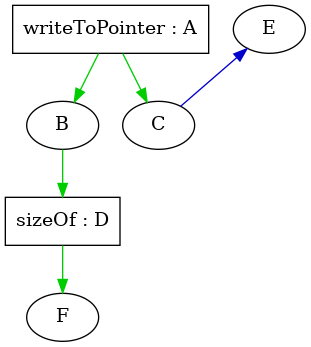

In [27]:
graph_visualisation.jupyter_display_graph(graph_visualisation.prolog_rule_to_dot(
        "bug(A) :- ast(A,B), ast(A,C), writeToPointer(A), ast(B,D), ref(C,E), ast(D,F), sizeOf(D)."
))

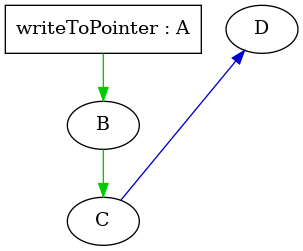

In [26]:
graph_visualisation.jupyter_display_graph(graph_visualisation.prolog_rule_to_dot(
        "bug(A) :- ast(A,B), writeToPointer(A), ast(B,C), ref(C,D)."
))

### `ancestor` and `writeToPointer`

In [42]:
header = """
% Settings
:- set(c,30)?
:- set(i,30)?
:- set(h,500)?
:- set(inflate,500)?

% Mode declarations
:- modeh(*, bug(+node))?

:- modeb(*, ref(+node,-node))?
:- modeb(*, ref(-node,+node))?

:- modeb(*, sizeOf(+node))?
:- modeb(*, malloc(+node))?
:- modeb(*, alloc(+node))?
:- modeb(*, writeToPointer(+node))?
:- modeb(*, ancestor(+node, -node))?
:- modeb(*, ast(+node, -node))?

ancestor(A,C) :- ast(A,B), ancestor(B,C).
ancestor(A,C) :- ast(A,B), ast(B,C).

writeToPointer(A) :- ast(A, B), assignment(A), compMemberAccess(B). 

"""

script = make_progol_script(header, {
    62804,
    62852,
    62853,
    62854,
    62869,
    62900,
    62901,
    62917,
    232012,
    232086,
})

with open("/tmp/progol_input.pl", "w") as f:
    f.write(script)

!/progol/source/progol /tmp/progol_input.pl

CProgol Version 5.0

[:- set(c,30)? - Time taken 0.00s]
[:- set(i,30)? - Time taken 0.00s]
[:- set(h,500)? - Time taken 0.00s]
[:- set(inflate,500)? - Time taken 0.00s]
[:- modeh(100,bug(+node))? - Time taken 0.00s]
[:- modeb(100,ref(+node,-node))? - Time taken 0.00s]
[:- modeb(100,ref(-node,+node))? - Time taken 0.00s]
[:- modeb(100,sizeOf(+node))? - Time taken 0.00s]
[:- modeb(100,malloc(+node))? - Time taken 0.00s]
[:- modeb(100,alloc(+node))? - Time taken 0.00s]
[:- modeb(100,writeToPointer(+node))? - Time taken 0.00s]
[:- modeb(100,ancestor(+node,-node))? - Time taken 0.00s]
[:- modeb(100,ast(+node,-node))? - Time taken 0.00s]
[Testing for contradictions]
[No contradictions found]
[Generalising bug/1]
[Generalising bug(bad_232086_id_146_f_memmove_01_c_l_30_c_8_).]
[Generalising <bug(bad_232086_id_146_f_memmove_01_c_l_30_c_8_).>]
bug(A) :- writeToPointer(A), ancestor(A,B), ancestor(A,C), ancestor(A,D), ast(A,E), ast(A,F), ast(A,G), ref(F,H), ref(G,I), sizeOf(C), ancestor(E,B), ast(

In [30]:
from importlib import reload
reload(graph_visualisation)

<module 'graph_visualisation' from '/project/code/graph_visualisation.py'>

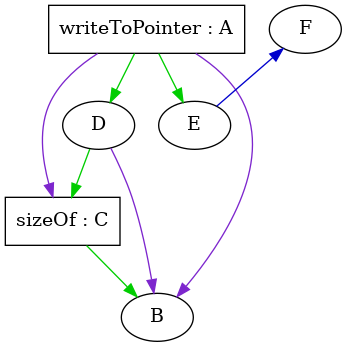

In [44]:
graph_visualisation.jupyter_display_graph(graph_visualisation.prolog_rule_to_dot(
        "bug(A) :- writeToPointer(A), ancestor(A,B), ancestor(A,C), ast(A,D), ast(A,E), ref(E,F), sizeOf(C), ancestor(D,B), ast(C,B), ast(D,C)."
))

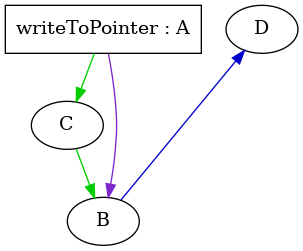

In [43]:
graph_visualisation.jupyter_display_graph(graph_visualisation.prolog_rule_to_dot(
        "bug(A) :- writeToPointer(A), ancestor(A,B), ast(A,C), ref(B,D), ast(C,B)."
))